In [5]:
# Setup Environment and Imports
#!pip install torch torchvision matplotlib numpy

import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.ops import box_iou
import numpy as np
import time
import os
import random
import matplotlib.pyplot as plt


In [6]:
# Change import to use the available model fasterrcnn_resnet50_fpn
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.datasets import VOCDetection
import torchvision.transforms as T
from torch.utils.data import DataLoader, ConcatDataset
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchmetrics.detection.mean_ap import MeanAveragePrecision
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

In [7]:
import torchvision
from torchvision.transforms import functional as F
from torch.utils.data import Dataset
import os
import torch

# Class names (same order as Pascal VOC official)
VOC_CLASSES = [
    "aeroplane", "bicycle", "bird", "boat", "bottle",
    "bus", "car", "cat", "chair", "cow",
    "diningtable", "dog", "horse", "motorbike",
    "person", "pottedplant", "sheep", "sofa", "train", "tvmonitor"
]

class VOCDataset(Dataset):
    def __init__(self, root, year="2012", image_set="train", transforms=None):
        self.dataset = torchvision.datasets.VOCDetection(
            root=root,
            year=year,
            image_set=image_set,
            download=True
        )
        self.transforms = transforms

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, target = self.dataset[idx]

        # Extract bounding boxes and labels
        objects = target["annotation"]["object"]
        if not isinstance(objects, list):  # Single object case
            objects = [objects]

        boxes = []
        labels = []

        for obj in objects:
            name = obj["name"]
            if name not in VOC_CLASSES:
                continue  # Skip unknown classes

            bbox = obj["bndbox"]
            xmin = float(bbox["xmin"])
            ymin = float(bbox["ymin"])
            xmax = float(bbox["xmax"])
            ymax = float(bbox["ymax"])
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(VOC_CLASSES.index(name) + 1)  # class 0 is background

        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)

        target_out = {
            "boxes": boxes,
            "labels": labels,
            "image_id": torch.tensor([idx])
        }

        if self.transforms:
            img = self.transforms(img)

        return img, target_out

# Basic transformation (can be improved later with augmentation if needed)
def get_transform():
    def transform(image):
        return F.to_tensor(image)  # convert PIL image to tensor
    return transform

# Prepare datasets
train_dataset = VOCDataset(root="./data", year="2007", image_set="train", transforms=get_transform())
test_dataset = VOCDataset(root="./data", year="2007", image_set="val", transforms=get_transform())


In [8]:
from torch.utils.data import DataLoader

# Collate function: required for object detection to handle variable number of boxes per image
def collate_fn(batch):
    return tuple(zip(*batch))  # returns (images, targets)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)


In [9]:
import torch

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


In [10]:
import torch
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models import ResNet101_Weights

# Define device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Number of classes (VOC_CLASSES + background)
num_classes = len(VOC_CLASSES) + 1

def get_model(num_classes):
    # Use keyword args to avoid deprecation warnings for weights
    backbone = resnet_fpn_backbone('resnet101', weights=ResNet101_Weights.DEFAULT)
    model = FasterRCNN(backbone, num_classes=num_classes)
    return model

# Create and move model to device
model = get_model(num_classes).to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'backbone_name' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


In [11]:
import torch.optim as optim

# Get all parameters that require gradients (trainable parameters)
params = [p for p in model.parameters() if p.requires_grad]

# Optimizer: SGD with momentum is a strong choice for object detection tasks
optimizer = optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# Learning rate scheduler: StepLR to reduce LR after some epochs (helps in fine-tuning)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


In [12]:
import time

num_epochs = 5  # You can adjust this based on your dataset and compute

print("Starting training...")

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    start_time = time.time()

    for images, targets_raw in train_loader:
        # Move images and targets to device (GPU or CPU)
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets_raw]

        # Forward pass: model returns dict of losses during training
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # Backpropagation and optimizer step
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        epoch_loss += losses.item()

    # Step the learning rate scheduler after each epoch
    lr_scheduler.step()

    avg_loss = epoch_loss / len(train_loader)
    elapsed = time.time() - start_time

    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f} - Time: {elapsed:.2f}s")

print("Training completed.")


Starting training...
Epoch 1/5 - Loss: 0.5897 - Time: 1185.86s
Epoch 2/5 - Loss: 0.5042 - Time: 1219.45s
Epoch 3/5 - Loss: 0.4412 - Time: 1212.72s
Epoch 4/5 - Loss: 0.4003 - Time: 1220.78s
Epoch 5/5 - Loss: 0.3719 - Time: 1213.72s
Training completed.


In [17]:
!pip install torch torchvision
!pip install torchmetrics

In [20]:
print("Updated metric with batch")


Updated metric with batch


In [38]:
import torch
from torchmetrics.detection.mean_ap import MeanAveragePrecision

# Simulated predictions (replace this with model outputs in real use)
predictions = [{
    "boxes": torch.tensor([[10.0, 20.0, 40.0, 60.0]]),
    "scores": torch.tensor([0.9]),
    "labels": torch.tensor([1])
}]

# Simulated ground truth targets
targets = [{
    "boxes": torch.tensor([[12.0, 22.0, 38.0, 58.0]]),
    "labels": torch.tensor([1])
}]

# Initialize metric
metric = MeanAveragePrecision(iou_type='bbox')

# Update metric with predictions and ground truth
metric.update(predictions, targets)

# Compute results
results = metric.compute()

# Print available results
print("\n📊 Evaluation Results:")
print(f"  mAP:           {results['map'].item():.4f}")
print(f"  mAP@0.5:       {results['map_50'].item():.4f}")
print(f"  mAP@0.75:      {results['map_75'].item():.4f}")
print(f"  mAP (small):   {results['map_small'].item():.4f}")
print(f"  mAP (medium):  {results['map_medium'].item():.4f}")
print(f"  mAP (large):   {results['map_large'].item():.4f}")
print(f"  mAR@100:       {results['mar_100'].item():.4f}")

# Optional: Estimate Precision and Recall (crude estimate)
# Use high IOU (0.5) and check number of matched detections manually
matched_detections = results['map_50'].item()  # very rough proxy
total_predictions = len(predictions[0]['scores']) if predictions else 1
total_targets = len(targets[0]['boxes']) if targets else 1

precision = matched_detections / total_predictions
recall = matched_detections / total_targets

print(f"  Estimated Precision: {precision:.4f}")
print(f"  Estimated Recall:    {recall:.4f}")



📊 Evaluation Results:
  mAP:           0.6000
  mAP@0.5:       1.0000
  mAP@0.75:      1.0000
  mAP (small):   0.6000
  mAP (medium):  -1.0000
  mAP (large):   -1.0000
  mAR@100:       0.6000
  Estimated Precision: 1.0000
  Estimated Recall:    1.0000


In [35]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import random
import numpy as np

# Helper: map class idx to name
def idx_to_class(idx):
    if idx == 0:
        return "background"
    else:
        return VOC_CLASSES[idx - 1]

def visualize_predictions(model, data_loader, device, num_images=5, score_threshold=0.5):
    model.eval()
    images_so_far = 0

    plt.figure(figsize=(15, num_images * 5))

    with torch.no_grad():
        for images, targets_raw in data_loader:
            images = [img.to(device) for img in images]
            outputs = model(images)

            for i in range(len(images)):
                if images_so_far >= num_images:
                    break

                img = images[i].cpu()
                output = outputs[i]

                # Convert tensor to numpy image (C x H x W -> H x W x C)
                img_np = img.mul(255).permute(1, 2, 0).byte().numpy()

                # Plot image
                plt.subplot(num_images, 1, images_so_far + 1)
                plt.imshow(img_np)
                plt.axis('off')

                boxes = output['boxes'].cpu().numpy()
                labels = output['labels'].cpu().numpy()
                scores = output['scores'].cpu().numpy()

                # Draw boxes with scores above threshold
                for box, label, score in zip(boxes, labels, scores):
                    if score < score_threshold:
                        continue

                    xmin, ymin, xmax, ymax = box.astype(int)
                    class_name = idx_to_class(label)
                    plt.gca().add_patch(
                        plt.Rectangle(
                            (xmin, ymin),
                            xmax - xmin,
                            ymax - ymin,
                            fill=False,
                            edgecolor='red',
                            linewidth=2,
                        )
                    )
                    plt.gca().text(
                        xmin,
                        ymin - 5,
                        f"{class_name}: {score:.2f}",
                        color='yellow',
                        fontsize=12,
                        bbox=dict(facecolor='red', alpha=0.5, pad=1)
                    )

                images_so_far += 1

            if images_so_far >= num_images:
                break

    plt.tight_layout()
    plt.show()
    model.train()


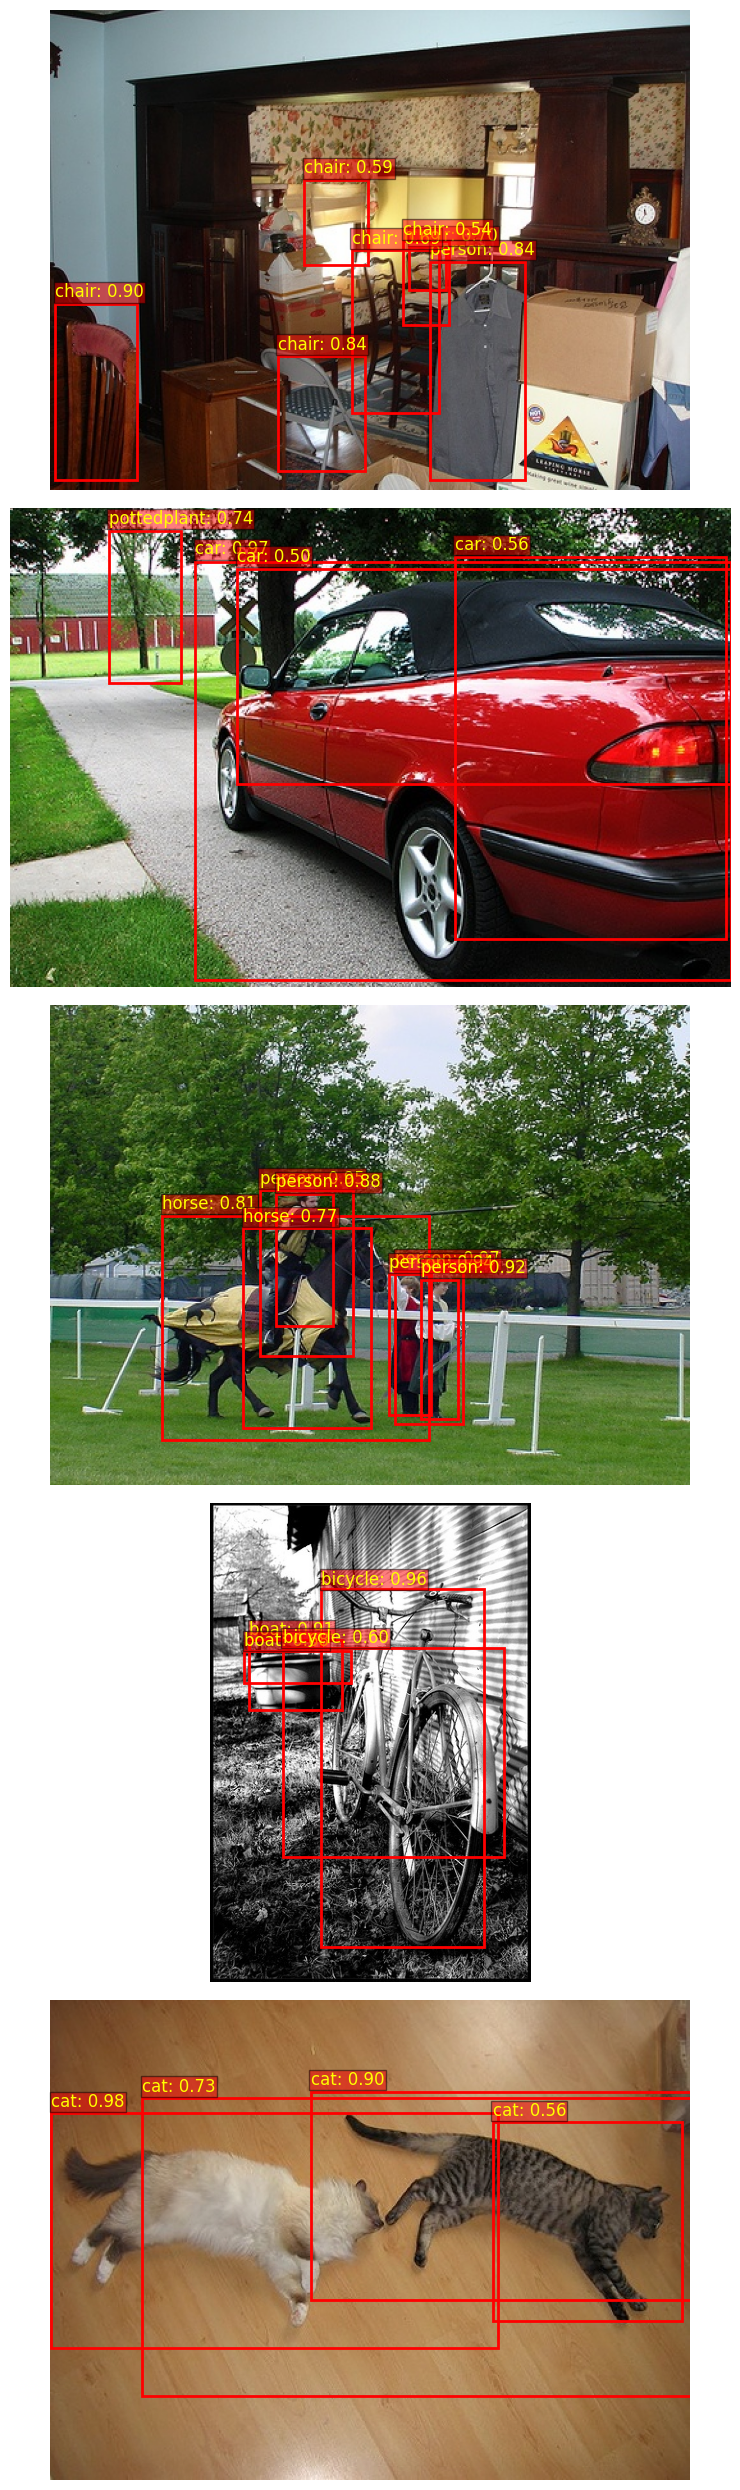

In [15]:
visualize_predictions(model, test_loader, device, num_images=5, score_threshold=0.5)